<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/Simple_1D_MLP_GAN_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D MLP Generative Adversarial Networks (GANs)
Este notebook inclui uma implementação de uma GAN 1D. Tudo, desde a preparação do ambiente até o treinamento da GAN, está incluído. Este código é aplicado para gerar uma linha reta onde "y = x". Essa abordagem proporcionará uma compreensão fundamental dos componentes e do funcionamento das GANs e de como elas podem ser utilizadas para uma GAN 1D.  

Uma tarefa simples que oferece um bom contexto para desenvolver uma GAN do zero é uma função unidimensional. Isso ocorre porque tanto as amostras reais quanto as geradas podem ser plotadas e inspecionadas visualmente, permitindo entender o que foi aprendido. Além disso, uma função simples não exige modelos de redes neurais sofisticados, o que facilita a compreensão dos modelos específicos de gerador e discriminador utilizados na arquitetura.

### Import Modules

In [1]:
# A module to transform data to NumPy arrays and create random noise
import numpy as np
from keras.models import Sequential
# Layers to be used in generator and discriminator
from keras.layers import Dense, LeakyReLU, Input
# A module to plot generated data
import matplotlib.pyplot as plt
from IPython import display

### Prepare and Pre-Process the Dataset

(1000, 1)
-1.0 1.0


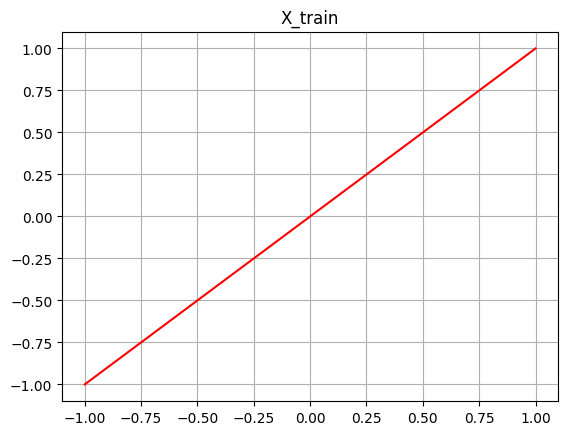

In [9]:
# Create variable X
X_train = np.linspace(-1, 1, 1000)
# Reshape X variable
X_train = X_train.reshape(-1, 1)
print(X_train.shape)
print(X_train.min(), X_train.max())
# Create variable Y such that y = x
y_train = X_train
# outra forma de curva: seno(x)
# y_train = np.sin(np.pi*X_train)
plt.plot(X_train, y_train, 'r')
plt.title('X_train')
plt.grid()
plt.show()

## Model Implementation

## Build the Generator
A arquitetura do gerador pode variar dependendo do problema específico a ser abordado. Geralmente, ele é composto por diversas camadas totalmente conectadas e de upsampling para aumentar a resolução da saída. No modelo de GAN 1D implementado, o gerador é construído utilizando um modelo sequencial do Keras. Ele começa com uma camada de entrada que recebe um vetor de ruído aleatório como entrada, com a dimensão do ruído definida como 100. Embora outros valores possam ser utilizados, um valor de 100 é frequentemente mencionado na literatura sobre implementação de GANs. A entrada é então processada por uma camada Dense com 16 unidades. Em seguida, é aplicada a função de ativação LeakyReLU com um valor alpha de 0,01 para lidar com valores de entrada negativos.  

Nas GANs, diversas funções de ativação podem ser empregadas, incluindo ReLU, Tanh, Sigmoid, Linear e LeakyReLU. A escolha da função de ativação depende do problema específico a ser resolvido. A camada Dense final possui uma função de ativação Linear e duas unidades de saída. A função de ativação Linear é utilizada na camada de saída do gerador para gerar valores contínuos sem um intervalo de restrição. Diferente de funções como Sigmoid ou Tanh, que limitam os valores de saída a um determinado intervalo, a ativação Linear permite que os valores de saída assumam qualquer valor real. Embora os dados de entrada estejam no intervalo entre -1 e 1, eles podem ser ajustados para se adequar a qualquer valor real. Portanto, o uso de uma função de ativação Linear na camada de saída do gerador é considerado apropriado neste cenário.

<center><img src='https://drive.google.com/uc?id=1UsFuT5CcafTfI4Sd-GFkh97cDRwIlipZ' width=600></center>

In [10]:
# from ast import Name
def build_generator(noise_dim):
  # Add layers one after one in the sequence
  model = Sequential(name='Generator')
  model.add(Input((noise_dim,)))
  # First fully connected layer
  model.add(Dense(16, kernel_initializer = 'he_uniform'))
  # Add LeakyReLU activation function
  model.add(LeakyReLU(0.01))
  # Output layer with the shape of 2
  # model.add(Dense(2, activation = 'linear'))
  model.add(Dense(2, activation = 'tanh'))
  return model

## Build the Discriminator
O discriminador em uma GAN avalia a autenticidade dos pontos gerados e os classifica como reais ou falsos. Ele é treinado para prever a probabilidade de que os pontos fornecidos sejam reais (extraídos do conjunto de dados real) ou falsos (gerados pelo gerador). O discriminador é implementado como uma rede neural profunda totalmente conectada com saída de classificação binária. A entrada do discriminador é treinada com dados reais para maximizar a probabilidade de classificá-los corretamente como reais.  

A arquitetura do discriminador é semelhante à de um classificador padrão, com várias camadas totalmente conectadas para extrair características dos pontos de dados de entrada e realizar a classificação final. A função de ativação usada no discriminador pode ser ReLU ou LeakyReLU, e a função de perda geralmente utilizada é a entropia cruzada binária (binary cross-entropy).  

A construção do discriminador da GAN utiliza o modelo sequencial da biblioteca Keras. O processo começa com a adição de uma camada totalmente conectada contendo 32 unidades, seguida pela aplicação da função de ativação LeakyReLU com um valor alpha de 0,01. O tensor de saída da camada totalmente conectada é então reduzido ao passar por outra camada totalmente conectada com oito unidades. Essa camada também é seguida por uma camada de ativação LeakyReLU com um valor alpha de 0,01. Por fim, uma camada Dense com uma função de ativação Sigmoid e uma única unidade é adicionada para gerar o resultado final da classificação binária.

<center><img src='https://drive.google.com/uc?id=1jqbj_X9O3fWtE53m9y1XIj1QyJ3Z_Ula' width=700></center>

In [13]:
def build_discriminator():
  # Add layers one after one in the sequence
  model = Sequential(name='Discriminator')
  model.add(Input((2,)))
  # First fully connected layer
  model.add(Dense(32, kernel_initializer = 'he_uniform'))
  # Add LeakyReLU activation function
  model.add(LeakyReLU(0.01))
  # Second fully connected layer
  model.add(Dense(8, kernel_initializer = 'he_uniform'))
  # Add LeakyReLU activation function
  model.add(LeakyReLU(0.01))
  # Output layer with the shape of 1
  model.add(Dense(1, activation = 'sigmoid'))

  return model

## Construct Models
Antes de treinar o modelo GAN e personalizar o loop de treinamento, é necessário construir os modelos e definir as funções de perda. Uma GAN é composta por dois modelos separados: um gerador e um discriminador, que são combinados em um terceiro modelo chamado adversarial. O discriminador é colocado sobre o gerador para formar o modelo adversarial.  

Algoritmos de otimização como Stochastic Gradient Descent (SGD), Adam Optimizer, RMSprop e Adagrad podem ser utilizados no treinamento da GAN. O Adam Optimizer é comumente usado, enquanto RMSprop e Adagrad podem ser empregados caso o SGD tenha dificuldades para convergir.  

No treinamento da GAN, são usadas duas funções de perda: uma para o modelo gerador e outra para o modelo discriminador. **O gerador tenta minimizar a perda, enquanto o discriminador tenta maximizá-la**. A função de perda do gerador é geralmente a entropia cruzada binária (binary cross-entropy), enquanto o discriminador pode usar tanto a entropia cruzada binária quanto a hinge loss. Tanto o modelo discriminador quanto o modelo adversarial são compilados com o otimizador Adam e a função de perda de entropia cruzada binária.  

Para construir o modelo adversarial (GAN), o discriminador é inicialmente definido como não treinável. Isso significa que, durante o treinamento do modelo adversarial, apenas o gerador será atualizado.

In [14]:
def construct_models(noise_dim):
      # Build the discriminator model
      discriminator = build_discriminator()
      # Compile the discriminator
      discriminator.compile(loss = 'binary_crossentropy' , optimizer = 'adam')
      # Build the generator model
      generator = build_generator(noise_dim)
      # Freeze the discriminator during generator training
      discriminator.trainable = False
      gan = Sequential(name='Gan')
      # Pit the generator and discriminator against each other
      gan.add(generator)
      gan.add(discriminator)
      # Compile the GAN model
      gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
      return generator, discriminator, gan

In [15]:
gen_, dis_, gan_ = construct_models(32)
gan_.summary()

Model: "Gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator (Sequential)          │ (None, 2)              │           562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │           369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 931 (3.64 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 369 (1.44 KB)

In [16]:
gen_.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562 (2.20 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
dis_.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 369 (1.44 KB)

## Define Loss Functions
O próximo passo é criar as funções de perda utilizadas durante o processo de treinamento para calcular as perdas do discriminador e do gerador. Nesta etapa, a função `train_on_batch` é empregada para treinar o modelo em um único lote de dados junto com seus respectivos rótulos. Em seguida, os parâmetros do modelo são atualizados com base na perda calculada entre os rótulos previstos e os rótulos reais.  

A função de perda do discriminador recebe como entrada os dados $ X $, que consistem em uma combinação de pontos de dados reais e falsos, juntamente com seus rótulos $ y $. Já a função de perda do gerador recebe como entrada o ruído gerado associado aos rótulos reais.

In [18]:
# Define discriminator loss function
def disc_loss(model, X, y):
	      # Train the model on a batch of data and return loss value
	      return model.train_on_batch(X,y)
# Define generator loss function
def gen_loss(model, X, y):
	      # Train the model on a batch of data and return loss value
	      return model.train_on_batch(X,y)

## Plot Generated Data Samples
Plotagem das Amostras de Dados Geradas. Antes de iniciar o treinamento do modelo GAN, é necessário definir uma função que permita a visualização dos pontos gerados. Essa função será chamada durante a fase de treinamento para avaliar o desempenho do modelo com base na qualidade dos pontos gerados.  

Os pontos reais e gerados serão plotados usando um gráfico de dispersão (*scatter plot*). No gráfico, as amostras reais serão representadas na cor vermelha, enquanto as amostras geradas serão representadas na cor azul.

In [19]:
def print_generated_samples(batch_size, noise_dim):
      # Create test data
      X_test = np.random.uniform(low=-1, high=1, size=(batch_size, 1))
      y_test = X_test # case of line
      # y_test = np.sin(np.pi*X_test)  # case of sine
      # Generate samples
      # noise = np.random.normal(0, 1, (batch_size, noise_dim))
      noise = np.random.uniform(low=-1, high=1, size=(batch_size, noise_dim))
      gen_data = generator.predict(noise, verbose=0)
      # Plot generated data
      plt.figure(figsize=(7, 5))
      #plt.scatter(X_test, y_test, color = 'red')
      plt.scatter(X_test, y_test, color = 'red', s=5, alpha=.5)
      plt.scatter(gen_data[:,0], gen_data[:,1], color = 'blue', s=6)
      plt.xlim(-1.5,1.5)
      plt.ylim(-1.5,1.5)
      plt.legend(["real data", "generated data"], loc = "lower right")
      plt.show()

## GAN Training
No treinamento de modelos GAN, o uso de épocas (*epochs*) e lotes (*batches*) é uma abordagem amplamente utilizada. O número de épocas determina por quanto tempo o modelo é exposto aos dados de treinamento – um número maior pode levar a um melhor desempenho, mas também aumenta o risco de *overfitting*. Por outro lado, o tamanho do lote (*batch size*) define a porção dos dados de treinamento usada para atualizar os pesos do modelo, influenciando tanto a velocidade quanto a estabilidade do treinamento. Um tamanho de lote maior pode melhorar o desempenho, mas exige mais recursos computacionais e tempo de processamento.  

Em cada época, o gerador e o discriminador são treinados alternadamente usando um lote de pontos de dados reais e gerados. Esse processo se repete por múltiplas épocas (neste caso, 600) para otimizar os pesos e alcançar o desempenho desejado. O número de lotes por época e o total de épocas são definidos com base no tamanho dos dados, na complexidade do modelo e no desempenho esperado. A complexidade do modelo, incluindo o número de camadas e neurônios, também influencia o desempenho. Modelos mais complexos podem obter melhores resultados, mas correm maior risco de *overfitting*.  

O treinamento termina quando o gerador passa a produzir amostras de $ y $ e $ x $ indistinguíveis dos pontos de dados reais. Isso significa que o gerador conseguiu enganar o discriminador com alta precisão. O desempenho do modelo será visualizado por meio de um gráfico em um eixo 2D, mostrando a evolução dos pontos gerados ao longo das épocas.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1daV8uUO9KbT-bk0EVC-QPBaifGfRpbKQ' width=600/>
<figcaption>Training stage in the discriminator</figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?id=1_rS0_sWnvXwFskR3AY9n7_T18EmIaLDL' width=700/>
<figcaption>Training stage in the generator</figcaption></center>
</figure>

In [20]:
def training(generator, discriminator, gan, noise_dim, epochs, batch_size):
  disc_loss_hist = []
  gen_loss_hist = []
  # Enumerate over epochs
  for e in range(epochs):
          # Random normal array for generator input
          noise = np.random.normal(0, 1, (batch_size, noise_dim))
          # Create fake images by the generator
          fake_samples = generator.predict(noise, verbose=0)
          # Stack X and Y variable horizontally to build the dataset
          real_data = np.hstack((X_train, y_train))
          # Get a random real data points from the training data
          real_data = real_data[np.random.randint(0, real_data.shape[0], size = batch_size)]
          # Create real labels
          real_labels = np.ones((batch_size, 1))*0.9 # smoothness 0.9
          # Generate fake labels generated data points as zeros
          fake_labels = np.zeros((batch_size, 1))

          # train discriminator
          discriminator.trainable = True
          # Calculate the loss of real data points. Train the model on a batch of data and return loss value
          discriminator_loss_real = disc_loss(discriminator, real_data, real_labels)
          # Calculate the loss of generated data points. Train the model on a batch of data and return loss value
          discriminator_loss_fake = disc_loss(discriminator, fake_samples, fake_labels)
          discriminator.trainable = False

          # Compute total discriminator loss
          discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
          disc_loss_hist.append(discriminator_loss)
          # Generate random points as input for the generator
          # x_gan = np.random.normal(0, 1, (batch_size, noise_dim))
          x_gan = np.random.uniform(low=-1, high=1, size=(batch_size, noise_dim))
          # generate real labels for gan
          y_gan = np.ones((batch_size, 1))
          #calculate the generator loss
          gan_loss = gen_loss(gan, x_gan, y_gan)
          gen_loss_hist.append(gan_loss)

          # Print the progress
          if e % 10 == 0 or e == epochs-1:
            display.clear_output(wait=True)
            print('Epoch: ', e, ' Generator Loss: ', gan_loss , ' Discriminator Loss: ', discriminator_loss)
            print_generated_samples(batch_size, noise_dim)

  return disc_loss_hist, gen_loss_hist

## Run the model
Para iniciar o processo de treinamento, é necessário primeiro chamar a função de treinamento e construir os modelos. Também é essencial definir o tamanho do lote (*batch size*) e o número de épocas (*epochs*), pois são parâmetros cruciais no processo de treinamento.  

Como mencionado anteriormente, o desempenho do modelo generativo durante o treinamento está diretamente relacionado ao número de iterações de treinamento, comumente chamadas de épocas. À medida que as épocas aumentam, os pontos de dados gerados tornam-se mais realistas e se assemelham mais aos dados de treinamento. Isso ocorre devido à melhoria da capacidade do gerador de enganar o discriminador.  

Serão apresentados múltiplos exemplos para destacar a relação entre o aumento do número de épocas e a qualidade dos pontos de dados gerados.

Epoch:  999  Generator Loss:  0.79720414  Discriminator Loss:  0.66254926


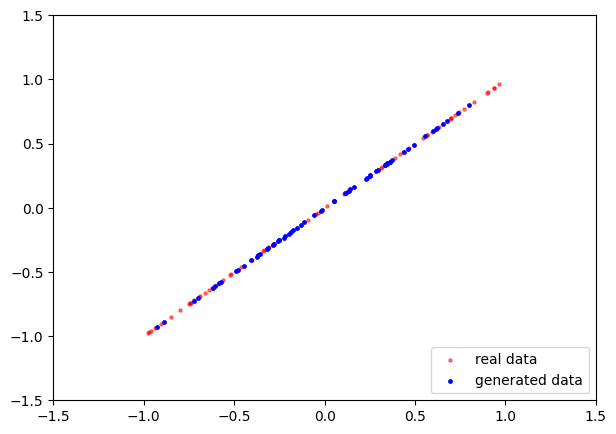

In [21]:
# Construct the models
noise_dim = 32
generator, discriminator, gan = construct_models(noise_dim)
# Train GAN
batch_size = 64
epochs = 1000
discriminator_loss, generator_loss = training(generator, discriminator, gan, noise_dim, epochs, batch_size)

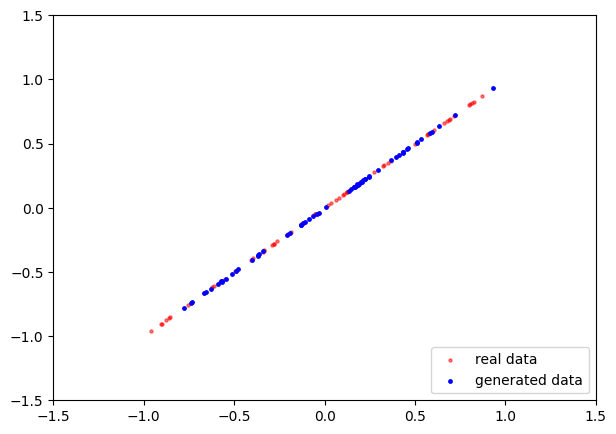

In [22]:
# Trained GAN prediction
print_generated_samples(batch_size, noise_dim)

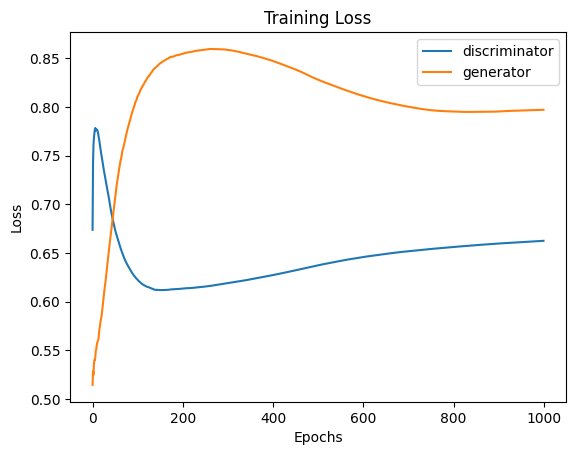

In [23]:
plt.plot(discriminator_loss, label='discriminator')
plt.plot(generator_loss, label='generator')
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Desafios Comuns ao Implementar GANs  
Diversos obstáculos e erros podem surgir ao construir e treinar um modelo GAN. Entre eles, está o *model collapse* (colapso do modelo), onde o gerador produz uma saída limitada e falha em capturar a diversidade dos dados. A instabilidade no treinamento do modelo, onde o gerador e o discriminador oscilam em vez de convergirem para uma solução estável, é outro erro comum. Além disso, o problema do gradiente que desaparece (*vanishing gradient*), onde os gradientes no processo de treinamento se tornam muito pequenos, também pode dificultar o treinamento do modelo.  

Outro obstáculo comum é o *overfitting* (sobreajuste), onde o modelo é excessivamente complexo e memoriza os dados de treinamento. A seleção de uma arquitetura de modelo apropriada, o ajuste de hiperparâmetros e o uso de técnicas de regularização podem ajudar a resolver esses problemas.

##Referências
[1] S. Kaddoura. **A Primer on Generative Adversarial Networks**, SpringerBriefs, Switzerland AG, 2023.

[2] https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

[3] https://gist.github.com/vedraiyani/46736bceb32fd81ee2d8733a7071a47e

[4] https://arxiv.org/abs/2312.09459

[5] https://www.sciencedirect.com/science/article/abs/pii/S0168169919326705

[6] https://www.kaggle.com/code/polomarco/1d-gan-for-ecg-synthesis

[7] [Redes Adversariais Generativas (GANs)](https://pownfmqo.manus.space/)

## Exercícios
1. Alterar a função de ativação do Gerador para *linear* e comparar o rendimento da rede.
1. Modificar o `negative_slope`=0.1, 0.2 e 0.3 da função *LeakyReLU* e verificar o rendimento da rede assim como o tempo de convergência.
1. Comentar o gráfico da perda (função custo) e verificar a oscilação da rede ao longo das épocas de treinamento e qual sua tendência.
1. Depois de treinada a rede, criar (ou utilizar uma biblioteca) de uma função métrica com a média dos erros quadráticos para comparações de rendemento da rede.
1. Alterar a arquitetura do gerador com uma camada inicial de 64 neurônios, seguida de uma camada oculta de 32 neurônios, depois outra camada oculta de 16 neurônios e a camada final de 2 neurônios. Mantenha as funções de ativação utilizadas. Compare os resultados e o rendimento da rede.
1. Modificar a função de treinamento da rede para uma parábola. Comente os resultados.
1. Modificar a função de treinamento da rede para uma senoide. Comente os resultados.